# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. 

填写并提交这份完成的工作表（包括其输出和工作表外部的任何支持代码）。

For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights
    
-为SVM实现完全矢量化的**损失函数**

-实现其**解析梯度**的完全矢量化表达式

-使用数字梯度**检查您的实现**

-使用验证集来**调整学习率和正则化强度**

-通过**SGD** **优化**损失函数

-**可视化**最终学习的权重


In [1]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
# 使matplotlib图形在笔记本中inline显示，而不是在新窗口中，是一种魔术。
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# 更多魔术，以便笔记本将重新加载外部python模块；
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
# cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
cifar10_dir = 'E:\cifar-10-batches-py'

# 清理变量以防止多次加载数据（这可能会导致内存问题）
# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# 作为健全性检查，我们打印出培训和测试数据的大小。
# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


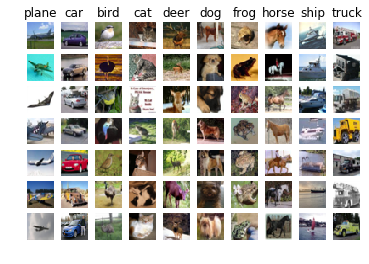

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
# 可视化数据集中的一些示例。
# 我们展示的每一类训练图像的几个例子。
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
# 将数据拆分为训练，验证和测试集。
# 另外，我们将创建一个小的开发集作为培训数据的子集；
# 我们可以将其用于开发，以便我们的代码运行更快。
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
# 我们的验证集将是原始训练集中的 num_validation 个点。
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
# 我们的训练集将是原始训练集的 前num_train 个点。
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
# 我们还将制作一个开发集，它是训练集的一小部分。
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
# 我们使用原始测试集的 前num_test 个点作为测试集。
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


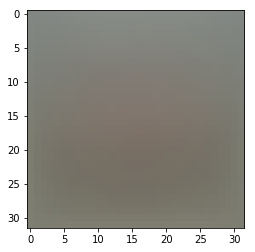

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
# 预处理：减去平均图像
# 第一：根据训练数据计算图像均值
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# 第二：从训练和测试数据中减去平均图像
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# 第三：附加一个bias维度（即bias技巧），以便我们的SVM仅需担心优化单个权重矩阵W。
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

您本节的代码将全部写在 **cs231n/classifiers/linear_svm.py**中。

如您所见，我们已经预填充了函数`compute_loss_naive`，该函数使用for循环来评估多类SVM损失函数。

In [7]:
# Evaluate the naive implementation of the loss we provided for you:
# 评估我们为您提供的损失的naive实现：
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# 生成随机SVM权重矩阵of small numbers
# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.494962


The `grad` returned from the function above is right now all zero. 

Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. 

You will find it helpful to interleave your new code inside the existing function.

从上面的函数返回的grad现在都为零。 

推导并实现 SVM cost 函数的梯度，并在函数`svm_loss_naive`中inline实现。 

您会发现将新代码插入现有函数中会很有帮助。

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. 

We have provided code that does this for you:

为了检查您是否正确正确地实现了梯度，可以对损失函数的梯度进行数字估计，并将数字估计与您计算出的梯度进行比较。

我们提供了为您执行此操作的代码：

In [8]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you
# 一旦你已经实现了梯度，用下面的代码重新计算它和用我们为您提供的函数检查梯度
# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# 沿几个随机选择的维度对梯度进行数值计算，然后将其与解析计算出的梯度进行比较。 
# 这些数字应在所有维度上几乎完全匹配。
# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# 在启用正则化功能的情况下再次进行梯度检查，您是否忘记了正则化梯度？
# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -21.301222 analytic: -21.301222, relative error: 1.086159e-11
numerical: -1.602184 analytic: -1.602184, relative error: 5.151163e-11
numerical: -2.230731 analytic: -2.230731, relative error: 9.565790e-11
numerical: -27.920813 analytic: -27.920813, relative error: 3.782028e-12
numerical: 11.604119 analytic: 11.604119, relative error: 1.104693e-11
numerical: -10.439158 analytic: -10.439158, relative error: 1.956881e-11
numerical: 13.778446 analytic: 13.796678, relative error: 6.611642e-04
numerical: -4.677813 analytic: -4.677813, relative error: 3.811459e-12
numerical: -9.546139 analytic: -9.448746, relative error: 5.127311e-03
numerical: 33.901458 analytic: 33.901458, relative error: 2.317758e-12
numerical: 19.448020 analytic: 19.454249, relative error: 1.601115e-04
numerical: 18.933607 analytic: 18.925860, relative error: 2.046266e-04
numerical: 1.246002 analytic: 1.241020, relative error: 2.003260e-03
numerical: -7.075070 analytic: -7.077927, relative error: 2.018515e-04
nu

**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. 

What could such a discrepancy be caused by? 

Is it a reason for concern? 

What is a simple example in one dimension where a gradient check could fail? 

How would change the margin affect of the frequency of this happening? 

*Hint: the SVM loss function is not strictly speaking differentiable*

有时gradcheck中的尺寸可能会不完全匹配。 

这种差异是由什么引起的？ 

这是引起关注的原因吗？ 

一个简单的示例在一维中梯度检查可能失败？ 

如何改变这种情况发生频率的边际效应?

*提示：SVM丢失功能严格来说是不可区分的*

$\color{blue}{\textit Your Answer:}$ *fill this in.*  


In [9]:
# Next implement the function svm_loss_vectorized; 
# for now only compute the loss;
# we will implement the gradient in a moment.
# 接下来实现svm_loss_vectorized函数;现在只计算损失;
# 我们马上就会实现gradient
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# 损失应该匹配，但是向量化实现应该快得多。
# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.494962e+00 computed in 0.147247s
Vectorized loss: 8.494962e+00 computed in 0.009999s
difference: 0.000000


In [10]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.
# 完成svm_loss_vectorized的实现，并以矢量化的方式计算损失函数的梯度。
# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
# 简单的实现和向量化的实现应该匹配，但是向量化的版本仍然要快得多。
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
# 损失是单个数字，因此很容易比较两个实现计算的值。
# 另一方面，梯度是一个矩阵，所以我们用 Frobenius范数 来比较它们。
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.148904s
Vectorized loss and gradient: computed in 0.003999s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. 

We are therefore ready to do SGD to minimize the loss.

我们现在有了矢量化的有效的损失表达式，梯度和我们的梯度匹配的数值梯度。

因此，我们准备做SGD以减少损失。

In [14]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 408.682255
iteration 100 / 1500: loss 241.768560
iteration 200 / 1500: loss 147.290024
iteration 300 / 1500: loss 91.026876
iteration 400 / 1500: loss 57.461883
iteration 500 / 1500: loss 36.704233
iteration 600 / 1500: loss 23.297398
iteration 700 / 1500: loss 16.303271
iteration 800 / 1500: loss 11.627644
iteration 900 / 1500: loss 9.048540
iteration 1000 / 1500: loss 7.291767
iteration 1100 / 1500: loss 6.757191
iteration 1200 / 1500: loss 6.336034
iteration 1300 / 1500: loss 5.733105
iteration 1400 / 1500: loss 5.444726
That took 9.455645s


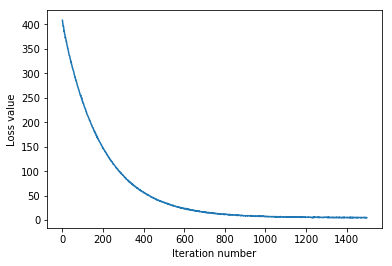

In [15]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
# 一个有用的调试策略是把损失描绘成迭代次数的函数:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [16]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
# 编写 LinearSVM.predict函数并评估训练集和验证集的性能
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.378673
validation accuracy: 0.385000


In [17]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 on the validation set.
# 使用验证集来调整超参数(正则化强度和学习率)。
# 你应该尝试不同的学习速率和正则化强度范围;
# 如果您小心的话，您应该能够在验证集上获得大约0.39的分类精度。
# Note: you may see runtime/overflow warnings during hyper-parameter search.
# This may be caused by extreme values, and is not a bug.
# 在超参数搜索期间，您可能会看到runtime/overflow警告。
# 这可能是由极端值引起的，而不是一个bug。

learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
# 结果是字典将表单的元组(learning_rate、regularization_strength)映射为
# 表单的元组(training_accuracy、validation_accuracy)。
# 精度就是被正确分类的数据点的分数。
results = {}
# The highest validation accuracy that we have seen so far.
# 迄今为止我们所看到的最高验证精度。
best_val = -1
# The LinearSVM object that achieved the highest validation rate.
# 获得了最高的验证率的线性支持向量机对象
best_svm = None

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
# 编写代码，通过调整验证集来选择最佳超参数。
# 对于每个超参数组合，在训练集上训练一个线性SVM，
# 在训练集和验证集上计算它的精度，
# 并将这些数字存储在结果字典中。
# 此外，在best_val中存储最佳验证精度，
# 而在best_svm中存储达到此精度的线性svm对象。
# 在开发验证代码时，应该为num_iter使用一个小值，这样svm就不会花费太多时间进行培训;
# 一旦您确信您的验证代码可以工作，您就应该为num_iter重新运行带有较大值的验证代码。
pass
# svm = LinearSVM()
# loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
#                       num_iters=1500, verbose=True)
for rs in regularization_strengths:
    for lr in learning_rates:
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, lr, rs, num_iters=3000)
        y_train_pred = svm.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = svm           
        results[(lr,rs)] = train_accuracy, val_accuracy
        
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
        lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

C:\Users\zzz\Desktop\spring1819_assignment123\assignment1\cs231n\classifiers\linear_svm.py:114: RuntimeWarning: overflow encountered in double_scalars
  loss += 0.5 * reg * np.sum(W * W) # 正则化损失（regularization loss）
D:\anacondathree\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\zzz\Desktop\spring1819_assignment123\assignment1\cs231n\classifiers\linear_svm.py:114: RuntimeWarning: overflow encountered in multiply
  loss += 0.5 * reg * np.sum(W * W) # 正则化损失（regularization loss）
C:\Users\zzz\Desktop\spring1819_assignment123\assignment1\cs231n\classifiers\linear_svm.py:109: RuntimeWarning: overflow encountered in subtract
  margin = np.maximum(0, scores - correct_class_scores + 1) # (N, C)
C:\Users\zzz\Desktop\spring1819_assignment123\assignment1\cs231n\classifiers\linear_svm.py:109: RuntimeWarning: invalid value encountered in subtract
  margin = np.maximum(0, scores - corre

lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.375918 val accuracy: 0.393000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.364571 val accuracy: 0.370000
lr 5.000000e-05 reg 2.500000e+04 train accuracy: 0.151959 val accuracy: 0.149000
lr 5.000000e-05 reg 5.000000e+04 train accuracy: 0.100265 val accuracy: 0.087000
best validation accuracy achieved during cross-validation: 0.393000


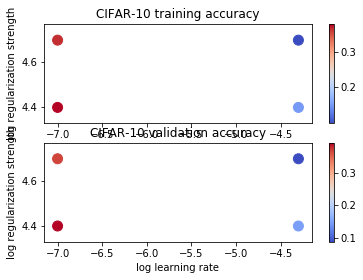

In [18]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [19]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.372000


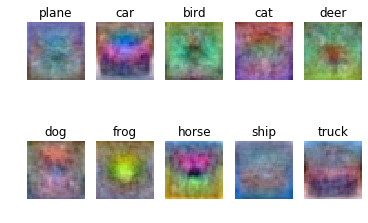

In [20]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
# 为每个类可视化学习权重。
# 根据您对学习速率和正则化强度的选择，这些可能看起来很好，也可能不太好。
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

描述您的可视化支持向量机权值是什么样子的，并提供一个简短的解释为什么它们看起来是这样的。

$\color{blue}{\textit Your Answer:}$ *fill this in*  


In [13]:
# yyyyyyy=np.array([[1,2,3],[4,5,6]])
# print(yyyyyyy)
# print(list(yyyyyyy))
# print(np.sum(yyyyyyy, axis=1))
# print(len(yyyyyyy))

# print(np.argmax(yyyyyyy, axis = 0))
# print(np.argmax(yyyyyyy, axis = 1))

[[1 2 3]
 [4 5 6]]
[array([1, 2, 3]), array([4, 5, 6])]
[ 6 15]
2
[1 1 1]
[2 2]
